In [3]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

root_path = Path("/home/olivieri/exp").resolve()
src_path = root_path / "src"
sys.path.append(f"{str(src_path)}")

In [4]:
from IPython.display import Markdown
from concurrent.futures import ThreadPoolExecutor, as_completed # for paralellism
import time
import re

from prompter import *
from data import *
from utils import *
from model import GoogleAIStudio

# Inference

In [5]:
# VLM
vlm = GoogleAIStudio(model="gemini-2.0-flash")

# Setting
BY_MODEL = "LRASPP_MobileNet_V3"
IMAGE_RESIZING_MODE = "letterboxed"
OUTPUT_MODE = "freeform"
SPLIT_BY = "class-splitted"

promptBuilder = PromptBuilder(
    by_model            = BY_MODEL,
    alpha               = 0.8,
    image_resizing_mode = IMAGE_RESIZING_MODE,
    output_mode         = OUTPUT_MODE,
    image_size          = (520, 520),
    array_size          = (32, 32),
    class_map           = CLASS_MAP, # imported from 'class_map.py'
    color_map           = COLOR_MAP_DICT,
    split_by            = SPLIT_BY
)

##  Class-splitted Inference

## Single Sample

In [11]:
promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = ClassSplitted_ColorMapModule(variation="default"),
    input_format_module     = SepMasks_Sc_InputFormatModule("original"),
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="3_specify_pos_class_recency")
)

In [12]:
query_idx = 0

In [13]:
class_splitted_inference_prompts, significant_classes = promptBuilder.build_class_splitted_inference_prompts(query_idx, return_significant_classes=True)

I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**. The scene, the ground truth and the prediction have been letterboxed to have the same dimension.


In both masks, a  color-class mapping is applied: the white color is mapped to the PERSON class, while the black color refers to unlabelled classes.


I will give you three images: the first image is the scene image, the second image is ground truth mask, the third image is the prediction mask.
Use the scene on the left to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


To help you, I will give you a set of example images, each associated with an ideal answer, which might mention classes whose names are irrelevant to your problem.


EXAMPLE 1.

Input:

Scene.

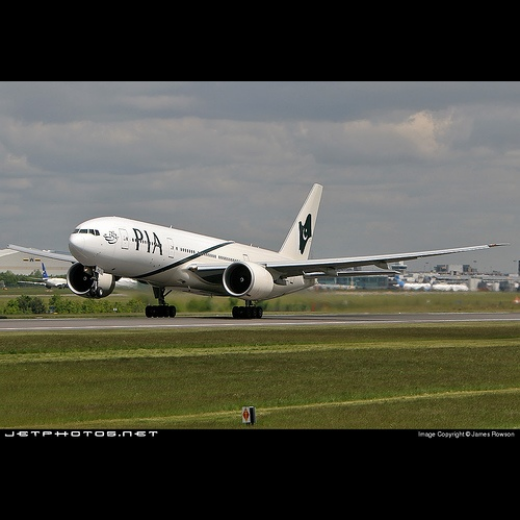

Ground Truth.

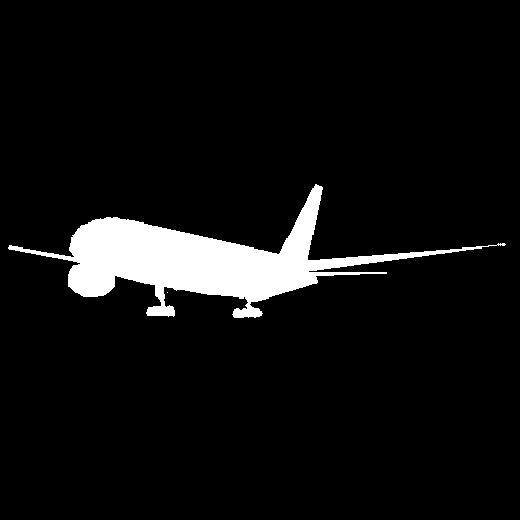

Prediction.

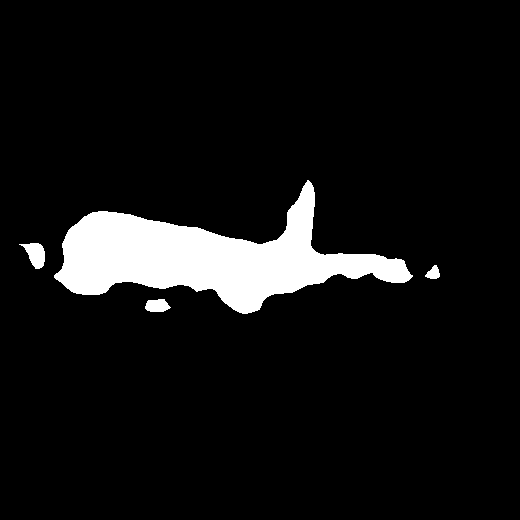

Output:

The prediction captured quite well the ground truth AEROPLANE region taking most of the scene, but there are some flaws. The boundaries of the prediction mask are somewhat imprecise and shaky, few areas are under-segmented, while others bleed into the surroundings.

EXAMPLE 2.

Input:

Scene.

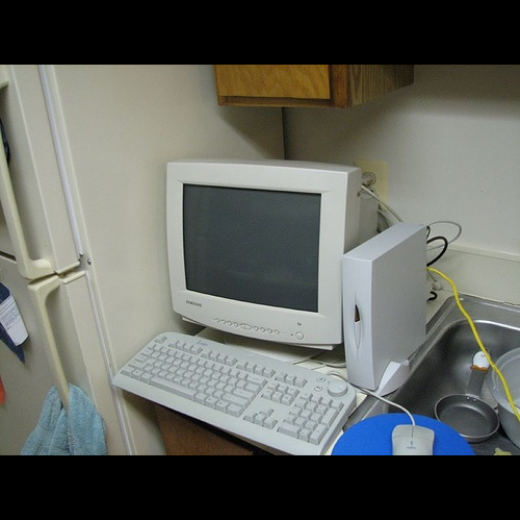

Ground Truth.

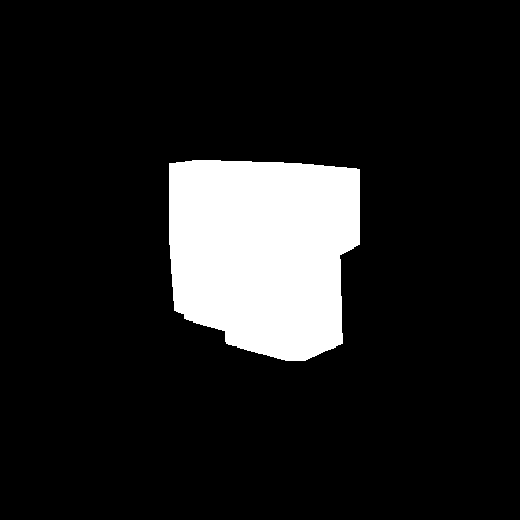

Prediction.

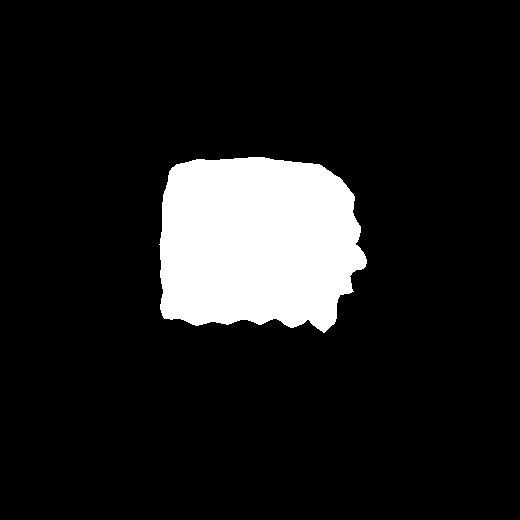

Output:

The ground truth TVMONITOR region on the center has mostly been segmented by the prediction but the boundaries are significantly inaccurate.

EXAMPLE 3.

Input:

Scene.

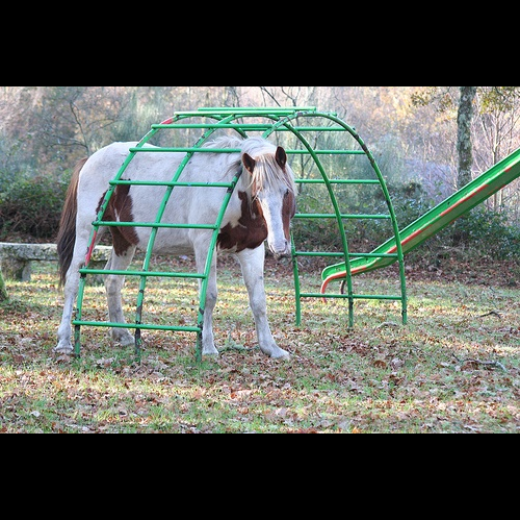

Ground Truth.

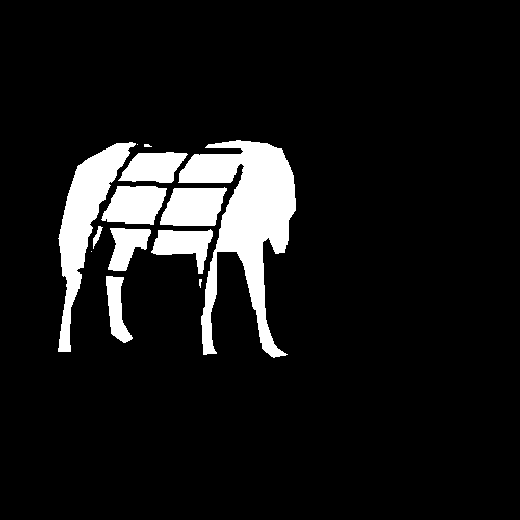

Prediction.

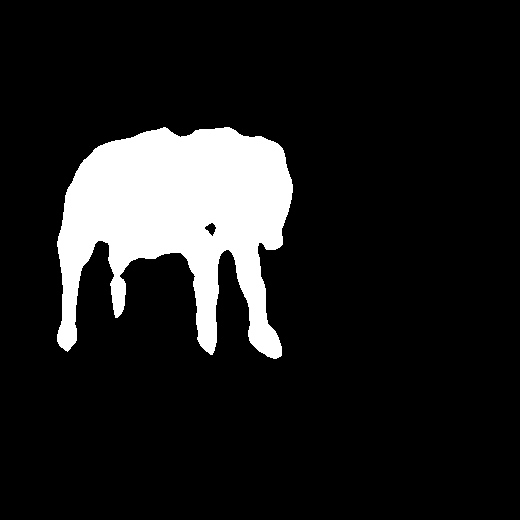

Output:

The prediction captured most of the ground truth HORSE region stretching from the center to the left of the scene, but the boundaries are slightly more imprecise and the HORSE class has been over-segmented on several stripes which are not HORSE in the ground truth.

Now, I ask you to generate the output based on following input. Remember the considered class is the PERSON class.


Input:

Scene.

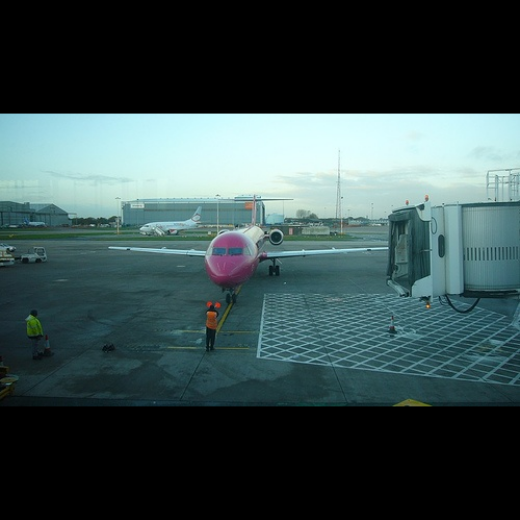

Ground Truth.

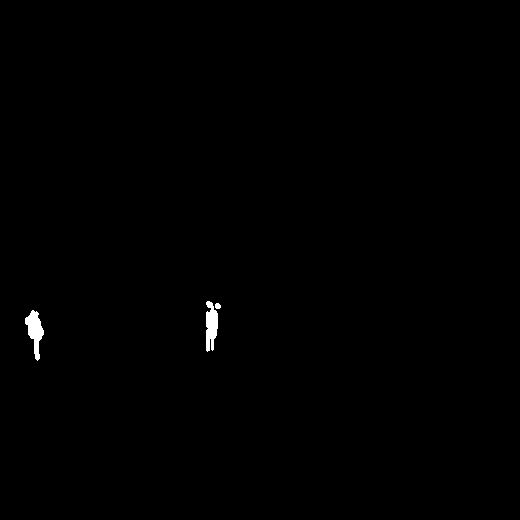

Prediction.

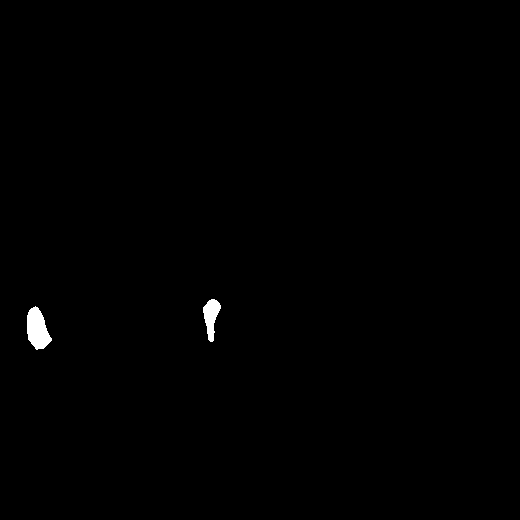

Output:

In [14]:
display_prompt(class_splitted_inference_prompts[1])

In [8]:
# The whole pipeline can be execute with these instructions:
pos_class_2_answer_pr = vlm.class_splitted_predict_one(promptBuilder, query_idx)
pos_class_2_eval_prompt = promptBuilder.build_class_splitted_eval_prompt(query_idx, pos_class_2_answer_pr)
pos_class_2_eval_pr = vlm.class_splitted_evaluate_one(pos_class_2_eval_prompt)

In [9]:
validate_pertinence(pos_class_2_answer_pr.values(), pos_class_2_answer_pr.keys())
validate_pertinence([d["reason"] for d in pos_class_2_eval_pr.values()], pos_class_2_eval_pr.keys())

## Pertinence Validation

In [10]:
input_format = ConcatMasks_Ovr_Hz_InputFormatModule("original")

promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = ClassSplitted_ColorMapModule(variation="default"),
    input_format_module     = input_format,
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="3_specify_pos_class_recency")
)

In [11]:
epoch_idxs = list(range(23))
epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
batches_idxs = partition_list(epoch_idxs, 7)
num_batches = len(batches_idxs)
batches_idxs

[[0, 1, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14], [15, 17, 19, 20, 21, 22]]

### Validate Answers

In [6]:
epoch_answer_pr_dicts = {}
prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
print(f"Evaluating {prompt_desc}.")
 
def process_class_splitted_predict(promptBuilder, query_idx):
    return query_idx, vlm.class_splitted_predict_one(promptBuilder, query_idx)

for i, batch_idxs in enumerate(batches_idxs):

    with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
        future_to_idx = {executor.submit(lambda idx: process_class_splitted_predict(promptBuilder, idx), query_idx): query_idx for query_idx in batch_idxs}
        for future in as_completed(future_to_idx):
            query_idx, answer_pr_dict = future.result()
            epoch_answer_pr_dicts[query_idx] = answer_pr_dict

    print(f"Batch {i+1}/{num_batches} completed.")

    time.sleep(60) if i < num_batches - 1 else None  # Sleep only if not the last batch

Evaluating ConcatMasks_Ovr_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.


In [8]:
for img_idx, pos_class_2_answer_pr in epoch_answer_pr_dicts.items():
    validate_pertinence(pos_class_2_answer_pr.values(), pos_class_2_answer_pr.keys())

### Validate Evals

In [10]:
epoch_eval_pr_dicts = {}
prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
print(f"Evaluating {prompt_desc}.")

def process_class_splitted_evaluate(promptBuilder, query_idx):
    pos_class_2_eval_prompt = promptBuilder.build_class_splitted_eval_prompt(query_idx, epoch_answer_pr_dicts[query_idx])
    return query_idx, vlm.class_splitted_evaluate_one(pos_class_2_eval_prompt)

for i, batch_idxs in enumerate(batches_idxs):

    with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
        future_to_idx = {executor.submit(lambda idx: process_class_splitted_evaluate(promptBuilder, idx), query_idx): query_idx for query_idx in batch_idxs}
        for future in as_completed(future_to_idx):
            query_idx, eval_pr_dict = future.result()
            epoch_eval_pr_dicts[query_idx] = eval_pr_dict

    print(f"Batch {i+1}/{num_batches} completed.")

    time.sleep(60) if i < num_batches - 1 else None  # Sleep only if not the last batch

Evaluating ConcatMasks_Ovr_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.


In [26]:
wrong_eval_idxs = []
n_evals = 0
for img_idx, pos_class_2_eval_pr in epoch_eval_pr_dicts.items():
    eval_reasons = [eval_pr["reason"] for eval_pr in pos_class_2_eval_pr.values()]
    n_evals += len(eval_reasons)
    try:
        validate_pertinence(eval_reasons, pos_class_2_eval_pr.keys())
    except:
        wrong_eval_idxs.append(img_idx)

In [41]:
len(wrong_eval_idxs)

2

In [32]:
wrong_idx = wrong_eval_idxs[1]
wrong_idx

10

In [48]:
print("GROUND TRUTH ANSWER:")
display(get_one_answer_gt(BY_MODEL, IMAGE_RESIZING_MODE, OUTPUT_MODE, SPLIT_BY, wrong_idx, False))
print("PREDICTED ANSWER:")
display(epoch_answer_pr_dicts[wrong_idx])
print("PREDICTED EVAL:")
display({k: v["reason"] for k, v in epoch_eval_pr_dicts[wrong_idx].items()})

GROUND TRUTH ANSWER:


{10: 'The prediction masks for the ground truth PERSON region stretching from the center to the bottom has mostly been segmented but in a quite irregular, imprecise way, few spots are missing, some are over-segmented or hallucinated. More in detail, a small patch has been placed on the padding in the bottom-left corner, one has been hallucinated on the top-right corner. A small ground truth patch of the same class on the left has mostly been segmented but with a blob-like shape. Moreover, the prediction missed most of the BOTTLE instances scattered in multiple places of the scene, and the instance that has been captured has been a bit over-segmented and has an imprecise shape.'}

PREDICTED ANSWER:


{5: 'The prediction only captured the leftmost BOTTLE region, but it is under-segmented and the boundaries are inaccurate. The other BOTTLE regions are completely missed by the prediction.\n',
 15: 'The prediction captured most of the ground truth PERSON region, but there are some noticeable differences. The prediction mask is missing a portion of the PERSON region on the left side of the scene. Additionally, there are some small, isolated regions of PERSON class in the prediction that are not present in the ground truth, particularly above the head. The boundary of the PERSON region is also slightly different between the ground truth and the prediction, especially around the shoulders and the hand holding the glass.\n'}

PREDICTED EVAL:


{5: 'The predicted answer correctly identifies that the prediction only captured the leftmost BOTTLE region, that it is under-segmented and the boundaries are inaccurate, and that the other BOTTLE regions are completely missed by the prediction. This aligns with the ground truth, which states that the prediction missed most of the BOTTLE instances scattered in multiple places of the scene, and the instance that has been captured has been a bit over-segmented and has an imprecise shape. Note that the predicted answer states that the leftmost BOTTLE region is under-segmented, while the ground truth states that the captured instance is over-segmented. However, the predicted answer is still considered correct because it captures the essence of the ground truth.',
 15: 'The predicted answer correctly identifies that the PERSON region has been mostly captured, but also points out missing portions and differences in the boundary, which aligns with the ground truth description of the PERSON se

## Single-Format Batch

In [12]:
input_format = ArrayMasks_InputFormatModule("original")

promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = ClassSplitted_ColorMapModule(variation="default"),
    input_format_module     = input_format,
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="3_specify_pos_class_recency")
)

epoch_eval_pr_dicts = {"state": promptBuilder.get_state()}

In [13]:
epoch_idxs = list(range(23))
epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
batches_idxs = partition_list(epoch_idxs, 4)
num_batches = len(batches_idxs)
batches_idxs

[[0, 1, 3, 4],
 [5, 6, 7, 8],
 [9, 10, 11, 12],
 [13, 14, 15, 17],
 [19, 20, 21, 22]]

In [14]:
prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
print(f"Evaluating {prompt_desc}.")

for i, batch_idxs in enumerate(batches_idxs):

    with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
        future_to_idx = {executor.submit(lambda idx: vlm.class_splitted_predict_and_evaluate_one(promptBuilder, idx, parse_to_dict=True), query_idx): query_idx for query_idx in batch_idxs}
        for future in as_completed(future_to_idx):
            query_idx, eval_pr_dict = future.result()
            epoch_eval_pr_dicts[query_idx] = eval_pr_dict

    print(f"Batch {i+1}/{num_batches} completed.")

    time.sleep(60) if i < num_batches - 1 else None  # Sleep only if not the last batch

Evaluating ArrayMasks.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.


In [15]:
exp_name = f"test_class_split/class-splitted/{prompt_desc}"

exp_path = get_eval_prs_path(promptBuilder.by_model, promptBuilder.image_resizing_mode, promptBuilder.output_mode, promptBuilder.split_by, exp_name)

append_many_to_jsonl(exp_path, format_many_to_jsonl(epoch_eval_pr_dicts))

## Multi-Format Batch

In [4]:
inputFormat_list = InputFormatModule.__subclasses__()
num_epochs = len(inputFormat_list)

In [5]:
inputFormat_list.remove(ArrayMasks_InputFormatModule)

In [6]:
all_epoch_eval_pr_dicts = {}
prompt_desc_list = []

for e, inputFormat in enumerate(inputFormat_list):

    input_format = inputFormat("original")

    promptBuilder.load_modules(
        context_module          = ContextModule(variation="default"),
        color_map_module        = ClassSplitted_ColorMapModule(variation="default"),
        input_format_module     = input_format,
        task_module             = TaskModule(variation="default"),
        output_format_module    = OutputFormatModule(variation="default"),
        support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
        query_module            = QueryModule(variation="default"),
        eval_module             = EvalModule(variation="3_specify_pos_class_recency")
    )

    epoch_eval_pr_dicts = {"state": promptBuilder.get_state()}

    epoch_idxs = list(range(23))
    epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
    batches_idxs = partition_list(epoch_idxs, 4)
    num_batches = len(batches_idxs)

    prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")

    print(f"Evaluating {prompt_desc}.")
    for i, batch_idxs in enumerate(batches_idxs):

        with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
            future_to_idx = {executor.submit(lambda idx: vlm.class_splitted_predict_and_evaluate_one(promptBuilder, idx, parse_to_dict=True), query_idx): query_idx for query_idx in batch_idxs}
            for future in as_completed(future_to_idx):
                query_idx, eval_pr_dict = future.result()
                epoch_eval_pr_dicts[query_idx] = eval_pr_dict

        print(f"Batch {i+1}/{num_batches} completed.")

        time.sleep(60) if (i < num_batches - 1 or e < num_epochs - 1) else None  # Sleep only if not the last batch

    prompt_desc_list.append(prompt_desc)
    all_epoch_eval_pr_dicts[prompt_desc] = epoch_eval_pr_dicts

Evaluating ConcatMasks_Sc_Hz.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.
Evaluating ConcatMasks_Sc_Vr.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.
Evaluating ConcatMasks_Ovr_Hz.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.
Evaluating ConcatMasks_Ovr_Vr.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.
Evaluating ConcatMasks_NoSc_Hz.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.
Evaluating ConcatMasks_NoSc_Vr.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.
Evaluating SepMasks_NoSc.
Batch 1/5 completed.
Batch 2/5 completed.
Batch 3/5 completed.
Batch 4/5 completed.
Batch 5/5 completed.
Evaluating SepMasks_Ovr.
Batch 1/5 completed.
Batch 2

In [7]:
for prompt_desc in prompt_desc_list:

    exp_name = f"test_class_split/class-splitted/{prompt_desc}"

    exp_path = get_eval_prs_path(promptBuilder.by_model, promptBuilder.image_resizing_mode, promptBuilder.output_mode, promptBuilder.split_by, exp_name)

    append_many_to_jsonl(exp_path, format_many_to_jsonl(all_epoch_eval_pr_dicts[prompt_desc]))